<a href="https://colab.research.google.com/github/18520395/CS114.K21/blob/master/sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mô tả bài toán:
- Input: Headline
- Output: Sarcasm hay không

Cách thu thập dataset:
- Thu thập các headline của các bài báo trên hai trang báo HuffPost và The Onion 
- Những headline từ HuffPost được đánh dấu non-sarcastic và từ The Onion là sarcastic
- Mỗi headline có 3 thuộc tính: headline, có sarcastic hay không (is_sarcastic) và article link (đường link đến article có headline trên)
- Với 2000 headlines mới chỉ lấy headlines vì phần link là không cần thiết
- Sử dụng Octoparse


In [68]:
!pip install nltk

In [69]:
#import libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib as plt
import json 
import seaborn as sns
import nltk
import string
import re
import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from sklearn.metrics import accuracy_score

In [70]:
#load libraries
from pandas import read_csv
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import wordnet
from bs4 import BeautifulSoup

In [71]:
#load dataset
url ='https://raw.githubusercontent.com/18520395/CS114.K21/master/Sarcasm_Headlines_Dataset_v2.json'
df = pd.read_json(url, lines = True)
url1 = 'https://raw.githubusercontent.com/18520395/CS114.K21/master/theonion1000.csv'
df1 = pd.read_csv(url1)

In [72]:
#dataset
df


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


In [73]:
df1

,Headline,is_sarcastic
0,MLS Commissioner Relieved That Nobody Knows Hi...,1
1,Study Finds Gap Widening Between Rich Pets And...,1
2,Heavily Armed Self-Help Gurus Demand America R...,1
3,Red Cross Announces It’s Fine Not To Perform L...,1
4,Ford Delays Launch Of New Bronco To Avoid O.J....,1
...,...,...
994,"Concerned Baby Starting To Worry Lethargic, Di...",1
995,"The Week In Pictures – Week Of February 24, 2020",1
996,Forever 21 Bought Following Bankruptcy,1
997,Trump Administration Rolls Back Hunting Regula...,1


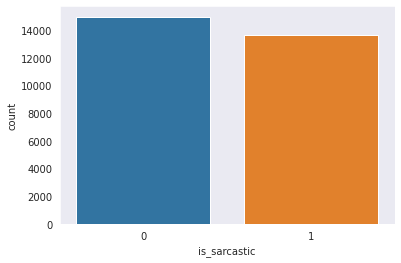

In [74]:
#visualize data
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

Xử lý dữ liệu:
- Bỏ article link ra khỏi dataset vì không cần thiết
- Bỏ các stopwords (những từ không ảnh hưởng đến ngữ nghĩa của headline) ra khỏi các headline
- Bỏ các ký hiệu thừa ({,},[,],\,/,...)

In [75]:
#prepare data
df = df.drop(['article_link'], axis=1)

In [76]:
#prepare data.2
#loading stopwords corpus
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#data cleaning
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#apply function on review column
df['headline']=df['headline'].apply(denoise_text)
df1['Headline']=df1['Headline'].apply(denoise_text)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails congress falling short ...
2,0,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word 'streamin...
...,...,...
28614,1,jews celebrate rosh hashasha something
28615,1,internal affairs investigator disappointed con...
28616,0,beautiful acceptance speech week came queer ko...
28617,1,mars probe destroyed orbiting spielberg-gates ...


Tạo danh sách từ vựng, các word vector 

In [77]:
#prepare data.3
words = []
for i in df.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)
    
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [78]:
words = []
for i in df1.Headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)
    
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x1 = sequence.pad_sequences(tokenized_train, maxlen = 20)

# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix


Chọn và train model:
- SVM
- Logistic RegressionRegression

In [79]:
#split data 
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.1 , random_state = 0) 
y_true = df1['is_sarcastic']
#load models

#SVM
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train,y_train)
y_pred = svm.predict(x_test)
accuracy_score(y_pred,y_test)
y_pred1 = svm.predict(x1)
accuracy_score(y_pred1,y_true)

0.24224224224224225

In [80]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(x_train,y_train)
y_pred = reg.predict(x_test)
accuracy_score(y_pred,y_test)
y_pred1 = reg.predict(x1)
accuracy_score(y_pred1,y_true)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.4024024024024024

accuracy_score là hàm so sánh tỉ lệ giữa kết quả dự đoán và kết quả thực
Performance của các model so với kernel của Madz2000 dùng Word2vec/GloVe đều thấp hơn và gần với nhau
Cả hai model đều có performace không tốt trên skew dataset